<a href="https://colab.research.google.com/github/sandesh-kun/Vton/blob/main/SLAMmap11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install opencv-python


In [12]:
!pip install pathfinding


In [13]:
!pip install numpy
!pip install open3d
!pip install matplotlib

## **Display**

In [14]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from matplotlib.pylab import *
from mpl_toolkits.mplot3d import Axes3D
import time

class Display:
    def __init__(self):
        self.W = 960
        self.H = 540

    def display_points2d(self, img, kpts, matches):
        if kpts != 0:
            for kpt in kpts:
                cv2.circle(img, (int(kpt.pt[0]), int(kpt.pt[1])), radius=2, color=(0,255,0), thickness=-1)

        if matches != 0:
            for match in matches:
                (u1, v1) = np.int32(match[0].pt)
                (u2, v2) = np.int32(match[1].pt)
                cv2.line(img, (u1, v1), (u2, v2), color=(0,0,255), thickness=1)
        return img

    def display_points3d(self, tripoints3d):

      """
        Visualize point cloud using matplotlib.

        Parameters:
        - tripoints3d: Nx3 numpy array of xyz coordinates
        """
      fig = plt.figure(figsize=(10, 10))
      ax = fig.add_subplot(111, projection='3d')

      x = tripoints3d[:, 0]
      y = tripoints3d[:, 1]
      z = tripoints3d[:, 2]

      ax.scatter(x, y, z, c='r', marker='o', s=0.5)

      ax.set_xlabel('X Label')
      ax.set_ylabel('Y Label')
      ax.set_zlabel('Z Label')

      plt.show()
        # open3d
        # if tripoints3d is not None:
        #     pcd.clear()
        #     pcd.points = o3d.utility.Vector3dVector(tripoints3d)
        #     visualizer.remove_geometry(pcd)
        #     visualizer.add_geometry(pcd)
        #     visualizer.poll_events()
        #     visualizer.update_renderer()
        #     time.sleep(.2)

    def display_vid(self, img):
        # Convert image from BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10,6)) # Optional, adjust the display size
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()


# **Extract**

In [15]:
import cv2
import numpy as np

class Extractor(object):
    def __init__(self):
        self.orb = cv2.ORB_create(nfeatures=1000, scoreType=cv2.ORB_FAST_SCORE)
        self.bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        self.last = None

    def extract_keypoints(self, img):
        # Detection
        if len(img.shape) > 2:
            pts = cv2.goodFeaturesToTrack(image=np.mean(img, axis=2).astype(np.uint8),
                                          maxCorners=4500, qualityLevel=0.02, minDistance=3)
        else:
            pts = cv2.goodFeaturesToTrack(image=img.astype(np.uint8),
                                          maxCorners=4500, qualityLevel=0.02, minDistance=3)

        # Extraction
        kpts = [cv2.KeyPoint(p[0][0], p[0][1], size=30) for p in pts]
        kpts, des = self.orb.compute(img, kpts)

        # Matching
        ret = []
        if self.last is not None:
            matches = self.bf.knnMatch(des, self.last["des"], k=2)
            for m, n in matches:
                if m.distance < 0.55 * n.distance and m.distance < 64:
                    kpt1_match = kpts[m.queryIdx]
                    kpt2_match = self.last["kpts"][m.trainIdx]
                    ret.append((kpt1_match, kpt2_match))

            coords1_match_pts = np.asarray([kpts[m.queryIdx].pt for m, n in matches])
            coords2_match_pts = np.asarray([self.last["kpts"][m.trainIdx].pt for m, n in matches])

            # Find transformation between two matched points
            retval, mask = cv2.findHomography(coords1_match_pts, coords2_match_pts, cv2.RANSAC, 100.0)
            mask = mask.ravel()

            pts1 = coords1_match_pts[mask == 1]
            pts2 = coords2_match_pts[mask == 1]

            self.last = {"kpts": kpts, "des": des}
            return pts1.T, pts2.T, kpts, ret

        else:
            self.last = {"kpts": kpts, "des": des}
            return np.array([0]), np.array([0]), [], []


# **Normalize**

In [16]:
import numpy as np


def scale_and_transform_points(points):
	x = points[0]
	y = points[1]

	center = points.mean(axis=1)

	cx = x - center[0]
	cy = y - center[1]

	distance = np.sqrt(np.power(cx, 2) + np.power(cy, 2))
	scale = np.sqrt(2) / distance.mean()

	norm3d = np.array([
		[scale, 0, -scale*center[0]],	#x
		[0, scale, -scale*center[1]],	#y
		[0, 0, 1]])			#z

	return np.dot(norm3d, points), norm3d


def correspondence_matrix(p1, p2):
	p1x, p1y = p1[:2]
	p2x, p2y = p2[:2]

	return np.array([
		p1x * p2x, p1x * p2y, p1x,
		p1y * p2x, p1y * p2y, p1y,
		p2x, p2y, np.ones(len(p1x))
		]).T

	return np.array([
		p2x * p1x, p2x * p1y, p2x,
        p2y * p1x, p2y * p1y, p2y,
        p1x, p1y, np.ones(len(p1x))
        ]).T


def compute_img_to_img_matrix(x1, x2, compute_essential=False):
	A = correspondence_matrix(x1, x2)
	U, S, V = np.linalg.svd(A)
	F = V[-1].reshape(3, 3)

	U, S, V = np.linalg.svd(F)
	S[-1] = 0
	if compute_essential:
		S = [1, 1, 0] # Force rank 2 and equal eigenvalues
	F = np.dot(U, np.dot(np.diag(S), V))

	return F


def compute_essential_normalized_matrix(p1, p2, compute_essential=False):
	if p1.shape != p2.shape:
		raise ValueError("Numbers of p1 and p2 don´t match !")

	# preprocess img coords
	p1n, T1 = scale_and_transform_points(p1)
	p2n, T2 = scale_and_transform_points(p2)

	# compute F
	F = compute_img_to_img_matrix(p1n, p2n, compute_essential)

	F = np.dot(T1.T, np.dot(F, T2))

	F = F / F[2, 2]

	return F


def compute_essential_normalized(p1, p2):
	return compute_essential_normalized_matrix(p1, p2, compute_essential=True)


def compute_P_from_essential(E):
	U, S, V = np.linalg.svd(E)

	if np.linalg.det(np.dot(U, V)) < 0:
		V = -V

	W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
	P2s = [
		np.vstack((np.dot(U, np.dot(W, V)).T, U[:, 2])).T,
		np.vstack((np.dot(U, np.dot(W, V)).T, -U[:, 2])).T,
		np.vstack((np.dot(U, np.dot(W.T, V)).T, U[:, 2])).T,
		np.vstack((np.dot(U, np.dot(W.T, V)).T, -U[:, 2])).T]

	return P2s


def skew(x):
	return np.array([
		[0, -x[2], x[1]],
		[x[2], 0, -x[0]],
		[-x[1], x[0], 0]])


def reconstruct_one_point(pt1, pt2, m1, m2):
	A = np.vstack([
		np.dot(skew(pt1), m1),
		np.dot(skew(pt2), m2)])

	U, S, V = np.linalg.svd(A)
	P = np.ravel(V[-1, :4])

	return P / P[3]


def triangulation(p1, p2, m1, m2):
	num_points = p1.shape[1]
	res = np.ones((4, num_points))

	for i in range(num_points):
		A = np.asarray([
			(p1[0, i] * m1[2, :] - m1[0, :]),
			(p1[1, i] * m1[2, :] - m1[1, :]),
			(p2[0, i] * m2[2, :] - m2[0, :]),
			(p2[1, i] * m2[2, :] - m2[1, :])])

		_, _, V = np.linalg.svd(A)
		X = V[-1, :4]
		res[:, i] = X / X[3]

	return res

# **Slam**

In [17]:
import cv2
import numpy as np
import open3d as o3d


display = Display()
extractor = Extractor()


def process(img):
	pts1, pts2, kpts, matches = extractor.extract_keypoints(img=img)

	# converto to 3 dimensional
	points1 = cart2hom(pts1)
	points2 = cart2hom(pts2)

	img_h, img_w, img_ch = img.shape

	intrinsic = np.array([[3000,0,img_w/2],
				[0,3000,img_h/2],
				[0,0,1]])
	tripoints3d = []
	if points1.ndim != 1 or points2.ndim != 1:
		points1_norm = np.dot(np.linalg.inv(intrinsic), points1)
		points2_norm = np.dot(np.linalg.inv(intrinsic), points2)

		E = compute_essential_normalized(points1_norm, points2_norm)

		P1 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])
		P2s = compute_P_from_essential(E)

		ind = -1
		for i, P2 in enumerate(P2s):
			d1 = reconstruct_one_point(points1_norm[:, 0], points2_norm[:, 0], P1, P2)

			P2_homogenous = np.linalg.inv(np.vstack([P2, [0,0,0,1]]))

			d2 = np.dot(P2_homogenous[:3, :4], d1)

			if d1[2] > 0 and d2[2] > 0:
				ind = i

		P2 = np.linalg.inv(np.vstack([P2s[ind], [0, 0, 0, 1]]))[:3, :4]
		tripoints3d = triangulation(points1_norm, points2_norm, P1, P2)

	else:
		print("Wrong dimension of array")
		pass

	return img, tripoints3d, kpts, matches

# **Pointmap**

In [18]:
import numpy as np
import open3d as o3d
import cv2


class PointMap(object):
	def __init__(self):
		self.array = [0,0,0]

	def collect_points(self, tripoints):
		if len(tripoints) > 0:
			array_to_project = np.array([0,0,0])

			x_points = [pt for pt in tripoints[0]]
			y_points = [-pt for pt in tripoints[1]]
			z_points = [-pt for pt in tripoints[2]]

			for i in range(tripoints.shape[1]):
				curr_array = np.array([x_points[i], y_points[i], z_points[i]])
				array_to_project = np.vstack((array_to_project, curr_array))

			array_to_project = array_to_project[1:, :]

			return array_to_project

Converter

In [19]:
import numpy as np
import open3d as o3d
import cv2


class PointMap(object):
	def __init__(self):
		self.array = [0,0,0]

	def collect_points(self, tripoints):
		if len(tripoints) > 0:
			array_to_project = np.array([0,0,0])

			x_points = [pt for pt in tripoints[0]]
			y_points = [-pt for pt in tripoints[1]]
			z_points = [-pt for pt in tripoints[2]]

			for i in range(tripoints.shape[1]):
				curr_array = np.array([x_points[i], y_points[i], z_points[i]])
				array_to_project = np.vstack((array_to_project, curr_array))

			array_to_project = array_to_project[1:, :]

			return array_to_project

# ***Convertor***

## **Main**

In [20]:
import cv2
import numpy as np


def cart2hom(array):
	"""Convert array from Cartesian -> Homogenous (2 dimensions -> 3 dimensions)"""
	if array.ndim == 1:
		return np.array([0])

	else:
		array_3dim = np.asarray(np.vstack([array, np.ones(array.shape[1])]))
		return array_3dim


<ipython-input-22-430347946ad0>:85: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-22-430347946ad0>:86: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-22-430347946ad0>:87: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-22-430347946ad0>:94: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
<ipython-input-22-430347946ad0>:95: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and wil

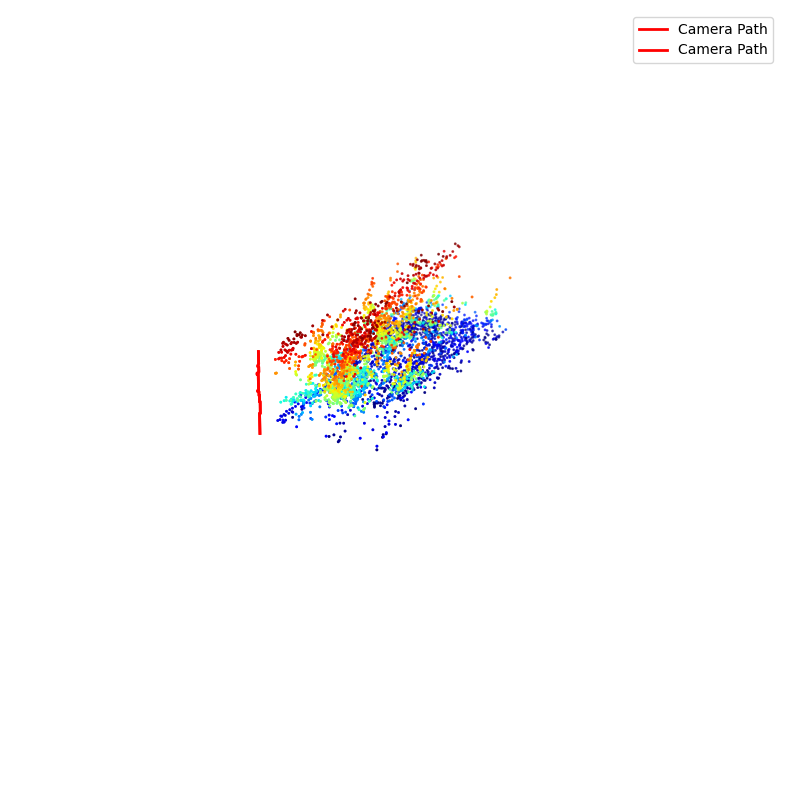

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()
zoom_out_factor = 500  # Define the zoom out factor here
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    camera_positions = []  # Store the camera positions here
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts and prev_keypoints and len(kpts) == len(prev_keypoints):
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])
        else:
            dx, dy = 0, 0

        x_offset += dx
        y_offset += dy
        z_offset += 1  # Increment for every frame

        # Convert 2D keypoints to 3D with displacements
        keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
        all_points_3d.extend(keypoints_3d)

        # Store the camera position for this frame
        camera_positions.append((x_offset, y_offset, z_offset))

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)
    np_cam_positions = np.array(camera_positions)  # Convert camera positions to numpy array

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for the keypoints
    ax.scatter(sampled_points[:,1], sampled_points[:,0], sampled_points[:,2], c=sampled_points[:,2], cmap='jet', s=1)

    # Plot for the camera movement
    ax.plot(np_cam_positions[:,1], np_cam_positions[:,0], np_cam_positions[:,2], color='red', linewidth=2, label="Camera Path")



    # Scatter plot for the keypoints
    ax.scatter(sampled_points[:, 1], sampled_points[:, 0], sampled_points[:, 2], c=sampled_points[:, 2], cmap='jet', s=1)

    # Plot for the camera movement
    ax.plot(np_cam_positions[:, 1], np_cam_positions[:, 0], np_cam_positions[:, 2], color='red', linewidth=2, label="Camera Path")

    # Increase the span of axis limits for a zoomed-out view
    if len(sampled_points) > 0:
      ax.set_ylim([np.min(sampled_points[:, 1]) - zoom_out_factor, np.max(sampled_points[:, 1]) + zoom_out_factor])
      ax.set_xlim([np.min(sampled_points[:, 0]) - zoom_out_factor, np.max(sampled_points[:, 0]) + zoom_out_factor])
      ax.set_zlim([np.min(sampled_points[:, 2]) - zoom_out_factor, np.max(sampled_points[:, 2]) + zoom_out_factor])

    # Turn off the axis grid
    ax.grid(False)

    # Set background color to white
    ax.set_facecolor('white')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Turn off the axis labels for a cleaner visualization
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Hide axes ticks
    for axis in ['x', 'y', 'z']:
        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])

    # Show the 3D plot
    plt.legend()  # To display the legend, especially useful to differentiate between the camera path and keypoints
    plt.show()

if __name__ == '__main__':
    process_video("/content/suuu.mp4")


## **Closure **

# ***This cell Gives Good result***

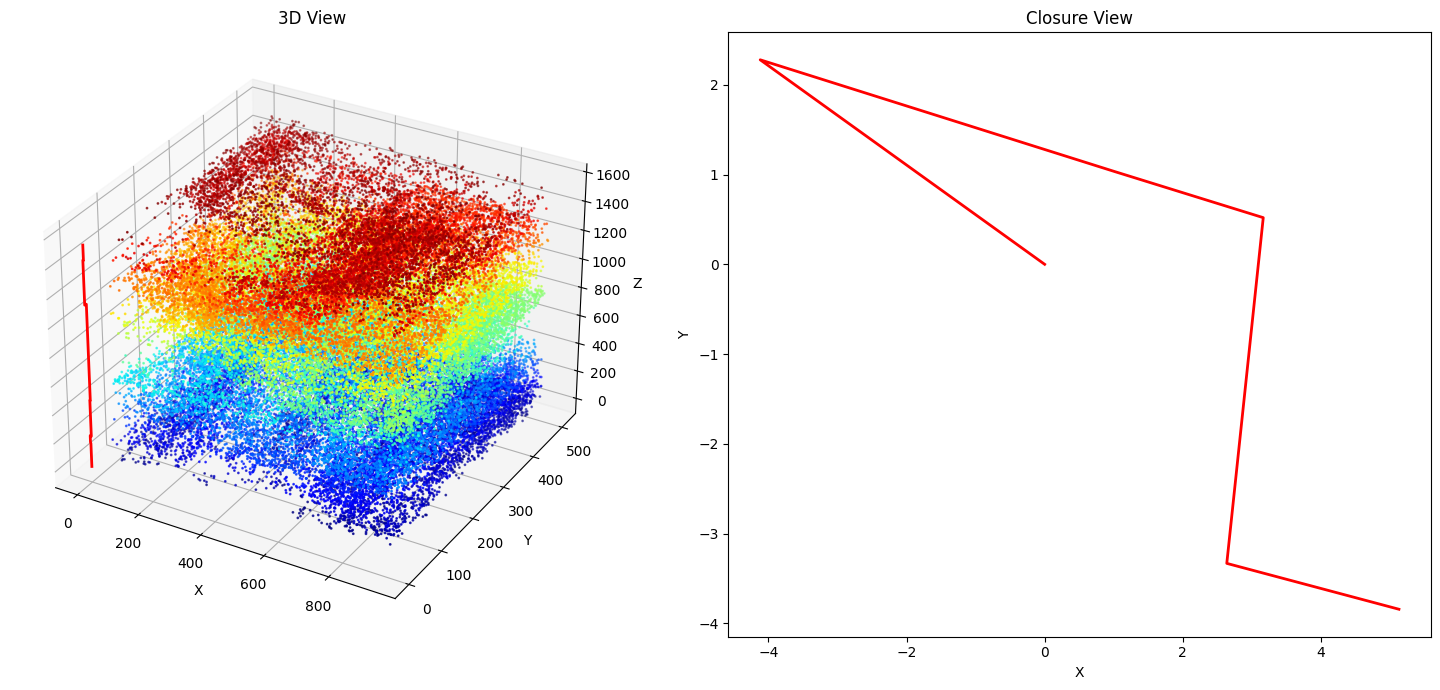

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()
zoom_out_factor = 500  # Define the zoom out factor here

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    camera_positions = []  # Store the camera positions here
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts and prev_keypoints and len(kpts) == len(prev_keypoints):
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])
        else:
            dx, dy = 0, 0

        x_offset += dx
        y_offset += dy
        z_offset += 1  # Increment for every frame

        # Convert 2D keypoints to 3D with displacements
        keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
        all_points_3d.extend(keypoints_3d)

        # Store the camera position for this frame
        camera_positions.append((x_offset, y_offset, z_offset))

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)
    np_cam_positions = np.array(camera_positions)  # Convert camera positions to numpy array

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    fig = plt.figure(figsize=(15, 7))

    # Subplot for the 3D view
    ax_3d = fig.add_subplot(121, projection='3d')
    ax_3d.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c=sampled_points[:, 2], cmap='jet', s=1)
    ax_3d.plot(np_cam_positions[:, 0], np_cam_positions[:, 1], np_cam_positions[:, 2], color='red', linewidth=2, label="Camera Path")
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')
    ax_3d.set_title('3D View')

    # Subplot for the top-down view (Closure View)
    ax_closure = fig.add_subplot(122)
    ax_closure.plot(np_cam_positions[:, 0], np_cam_positions[:, 1], color='red', linewidth=2, label="Camera Path")
    ax_closure.set_xlabel('X')
    ax_closure.set_ylabel('Y')
    ax_closure.set_title('Closure View')

    # Show the 3D plot
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    process_video("/content/new.mp4")


# **Aug 28**

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder



# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()
zoom_out_factor = 500  # Define the zoom out factor here

# Define the grid cell size
GRID_CELL_SIZE = 10  # Adjust this based on your environment

def create_grid_from_cam_positions(cam_positions):
    # Determine the dimensions of the grid
    max_x = int(max(pos[0] for pos in cam_positions))
    max_y = int(max(pos[1] for pos in cam_positions))

    # Create the grid
    grid_width = int(max_x / GRID_CELL_SIZE) + 1
    grid_height = int(max_y / GRID_CELL_SIZE) + 1
    grid = np.zeros((grid_width, grid_height), dtype=bool)

    # Simulate marking random obstacles on the grid (adapt this to your actual data)
    num_obstacles = 50  # Number of obstacles to place
    obstacle_positions = np.random.randint(0, grid.shape[0], (num_obstacles, 2))  # Random obstacle positions

    # Mark obstacle cells as True in the grid
    for obstacle in obstacle_positions:
        grid[obstacle[0], obstacle[1]] = True

    return grid

def astar_search(grid, start, goal):
    grid_instance = Grid(matrix=grid)
    start_node = grid_instance.node(start[0], start[1])
    goal_node = grid_instance.node(goal[0], goal[1])

    finder = AStarFinder()
    path, _ = finder.find_path(start_node, goal_node, grid_instance)

    return path

def get_neighbors(cell, grid):
    x, y = cell
    neighbors = []

    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            new_x = x + dx
            new_y = y + dy

            if 0 <= new_x < grid.shape[0] and 0 <= new_y < grid.shape[1] and not grid[new_x, new_y]:
                neighbors.append((new_x, new_y))

    return neighbors

def integrate_path_planning(cam_positions):
    # Convert camera positions to grid coordinates based on GRID_CELL_SIZE
    grid_positions = [(int(x // GRID_CELL_SIZE), int(y // GRID_CELL_SIZE)) for x, y in cam_positions]
    # Determine start and goal positions (adjust these as needed)
    start = grid_positions[0]
    goal = grid_positions[-1]

    # Create the grid for pathfinding
    grid = create_grid_from_cam_positions(grid_positions)

    # Find the path using A* search
    path = astar_search(grid, start, goal)

    # Convert path back to real-world coordinates
    planned_path = np.array([(p[0] * GRID_CELL_SIZE, p[1] * GRID_CELL_SIZE) for p in path])

    return planned_path


def process_video(video_path, planned_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    camera_positions = []  # Store the camera positions here
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts and prev_keypoints and len(kpts) == len(prev_keypoints):
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])
        else:
            dx, dy = 0, 0

        x_offset += dx
        y_offset += dy
        z_offset += 1  # Increment for every frame

        # Convert 2D keypoints to 3D with displacements
        keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
        all_points_3d.extend(keypoints_3d)

        # Store the camera position for this frame
        camera_positions.append((x_offset, y_offset, z_offset))

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)
    np_cam_positions = np.array(camera_positions)  # Convert camera positions to numpy array

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    fig = plt.figure(figsize=(15, 7))

    # Subplot for the 3D view
    ax_3d = fig.add_subplot(121, projection='3d')
    ax_3d.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c=sampled_points[:, 2], cmap='jet', s=1)
    ax_3d.plot(np_cam_positions[:, 0], np_cam_positions[:, 1], np_cam_positions[:, 2], color='red', linewidth=2, label="Camera Path")
    ax_3d.plot(planned_path[:, 0], planned_path[:, 1], [z_offset] * len(planned_path), color='green', linewidth=2, label="Planned Path")  # Add planned path
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')
    ax_3d.set_title('3D View')

    # Subplot for the top-down view (Closure View)
    ax_closure = fig.add_subplot(122)
    ax_closure.plot(np_cam_positions[:, 0], np_cam_positions[:, 1], color='red', linewidth=2, label="Camera Path")
    ax_closure.plot(planned_path[:, 0], planned_path[:, 1], color='green', linewidth=2, label="Planned Path")  # Add planned path
    ax_closure.set_xlabel('X')
    ax_closure.set_ylabel('Y')
    ax_closure.set_title('Closure View')

    # Show the 3D plot
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Load your video
    video_path = "/content/rest.mp4"
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    camera_positions = []  # Store the camera positions here
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts and prev_keypoints and len(kpts) == len(prev_keypoints):
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])
        else:
            dx, dy = 0, 0

        x_offset += dx
        y_offset += dy
        z_offset += 1  # Increment for every frame

        # Convert 2D keypoints to 3D with displacements
        keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
        all_points_3d.extend(keypoints_3d)

        # Store the camera position for this frame
        camera_positions.append((x_offset, y_offset, z_offset))

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)
    np_cam_positions = np.array(camera_positions)  # Convert camera positions to numpy array

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    # Integrate path planning
    planned_path = integrate_path_planning(np_cam_positions[:, :2])

    # Process the video and display the result
    process_video(video_path, planned_path)


KeyboardInterrupt: ignored

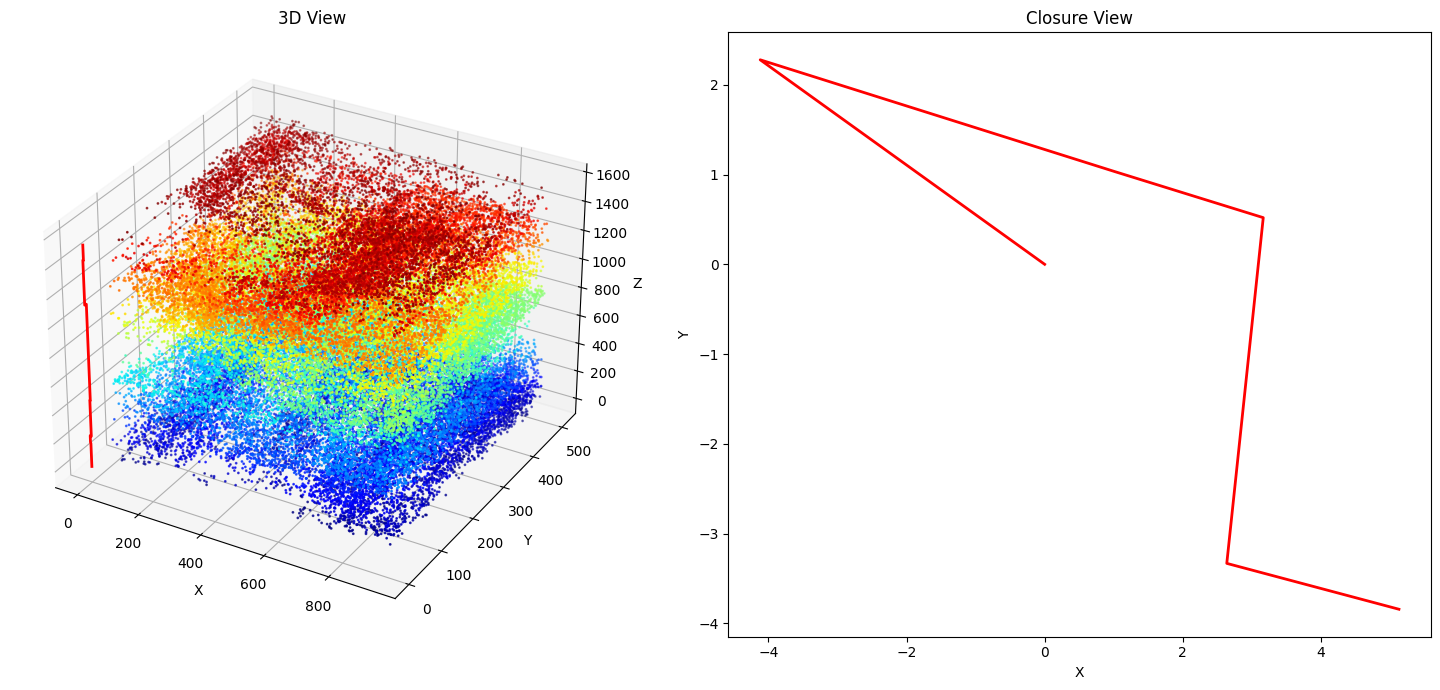

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder



# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()
zoom_out_factor = 500  # Define the zoom out factor here

# Define the grid cell size
GRID_CELL_SIZE = 10  # Adjust this based on your environment

def create_grid_from_cam_positions(cam_positions):
    # Determine the dimensions of the grid
    max_x = int(max(pos[0] for pos in cam_positions))
    max_y = int(max(pos[1] for pos in cam_positions))

    # Create the grid
    grid_width = int(max_x / GRID_CELL_SIZE) + 1
    grid_height = int(max_y / GRID_CELL_SIZE) + 1
    grid = np.zeros((grid_width, grid_height), dtype=bool)

    # Simulate marking random obstacles on the grid (adapt this to your actual data)
    num_obstacles = 50  # Number of obstacles to place
    obstacle_positions = np.random.randint(0, grid.shape[0], (num_obstacles, 2))  # Random obstacle positions

    # Mark obstacle cells as True in the grid
    for obstacle in obstacle_positions:
        grid[obstacle[0], obstacle[1]] = True

    return grid

def astar_search(grid, start, goal):
    grid_instance = Grid(matrix=grid)
    start_node = grid_instance.node(start[0], start[1])
    goal_node = grid_instance.node(goal[0], goal[1])

    finder = AStarFinder()
    path, _ = finder.find_path(start_node, goal_node, grid_instance)

    return path

def get_neighbors(cell, grid):
    x, y = cell
    neighbors = []

    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            new_x = x + dx
            new_y = y + dy

            if 0 <= new_x < grid.shape[0] and 0 <= new_y < grid.shape[1] and not grid[new_x, new_y]:
                neighbors.append((new_x, new_y))

    return neighbors

def integrate_path_planning(cam_positions):
    # Convert camera positions to grid coordinates based on GRID_CELL_SIZE
    grid_positions = [(int(x // GRID_CELL_SIZE), int(y // GRID_CELL_SIZE)) for x, y in cam_positions]
    # Determine start and goal positions (adjust these as needed)
    start = grid_positions[0]
    goal = grid_positions[-1]

    # Create the grid for pathfinding
    grid = create_grid_from_cam_positions(grid_positions)

    # Find the path using A* search
    path = astar_search(grid, start, goal)

    # Convert path back to real-world coordinates
    planned_path = np.array([(node.x * GRID_CELL_SIZE, node.y * GRID_CELL_SIZE) for node in path])


    return planned_path


def process_video(video_path, planned_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    camera_positions = []  # Store the camera positions here
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts and prev_keypoints and len(kpts) == len(prev_keypoints):
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])
        else:
            dx, dy = 0, 0

        x_offset += dx
        y_offset += dy
        z_offset += 1  # Increment for every frame

        # Convert 2D keypoints to 3D with displacements
        keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
        all_points_3d.extend(keypoints_3d)

        # Store the camera position for this frame
        camera_positions.append((x_offset, y_offset, z_offset))

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)
    np_cam_positions = np.array(camera_positions)  # Convert camera positions to numpy array

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    fig = plt.figure(figsize=(15, 7))

    # Subplot for the 3D view
    ax_3d = fig.add_subplot(121, projection='3d')
    ax_3d.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c=sampled_points[:, 2], cmap='jet', s=1)
    ax_3d.plot(np_cam_positions[:, 0], np_cam_positions[:, 1], np_cam_positions[:, 2], color='red', linewidth=2, label="Camera Path")
    ax_3d.plot(planned_path[:, 0], planned_path[:, 1], [z_offset] * len(planned_path), color='green', linewidth=2, label="Planned Path")  # Add planned path
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')
    ax_3d.set_title('3D View')

    # Subplot for the top-down view (Closure View)
    ax_closure = fig.add_subplot(122)
    ax_closure.plot(np_cam_positions[:, 0], np_cam_positions[:, 1], color='red', linewidth=2, label="Camera Path")
    ax_closure.plot(planned_path[:, 0], planned_path[:, 1], color='green', linewidth=2, label="Planned Path")  # Add planned path
    ax_closure.set_xlabel('X')
    ax_closure.set_ylabel('Y')
    ax_closure.set_title('Closure View')

    # Show the 3D plot
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Load your video
    video_path = "/content/new.mp4"
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    camera_positions = []  # Store the camera positions here
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts and prev_keypoints and len(kpts) == len(prev_keypoints):
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])
        else:
            dx, dy = 0, 0

        x_offset += dx
        y_offset += dy
        z_offset += 1  # Increment for every frame

        # Convert 2D keypoints to 3D with displacements
        keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
        all_points_3d.extend(keypoints_3d)

        # Store the camera position for this frame
        camera_positions.append((x_offset, y_offset, z_offset))

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)
    np_cam_positions = np.array(camera_positions)  # Convert camera positions to numpy array

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    # Integrate path planning
    planned_path = integrate_path_planning(np_cam_positions[:, :2])

    # Process the video and display the result
    process_video(video_path, planned_path)


## **Camera path**

<ipython-input-31-d55960024c78>:66: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-31-d55960024c78>:67: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-31-d55960024c78>:68: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-31-d55960024c78>:75: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
<ipython-input-31-d55960024c78>:76: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and wil

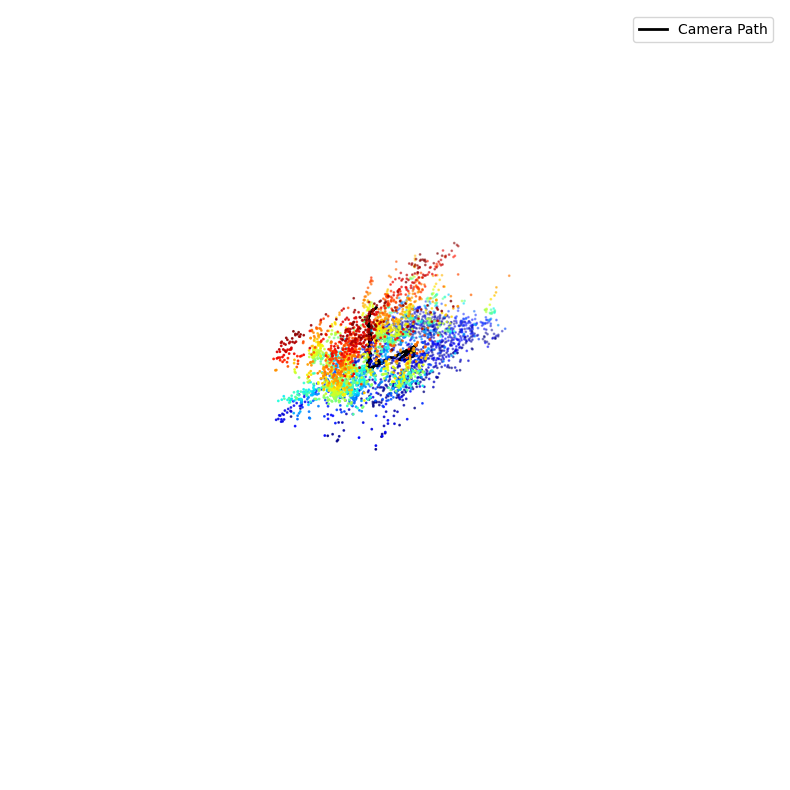

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()
zoom_out_factor = 500  # Define the zoom out factor here

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    camera_positions = []  # Store the camera positions here
    z_offset = 0  # Increment for every frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))
        img, tripoints, kpts, matches = process(frame)

        # Convert 2D keypoints to 3D with displacements
        keypoints_3d = [(kp.pt[0], kp.pt[1], z_offset) for kp in kpts]
        all_points_3d.extend(keypoints_3d)

        # Store the average camera position for this frame as the mean of the keypoints
        avg_x = np.mean([kp[0] for kp in keypoints_3d])
        avg_y = np.mean([kp[1] for kp in keypoints_3d])
        camera_positions.append((avg_x, avg_y, z_offset))

        z_offset += 1  # Increment for every frame

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)
    np_cam_positions = np.array(camera_positions)  # Convert camera positions to numpy array

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for the keypoints
    ax.scatter(sampled_points[:, 1], sampled_points[:, 0], sampled_points[:, 2], c=sampled_points[:, 2], cmap='jet', s=1)

    # Plot for the camera movement
    ax.plot(np_cam_positions[:, 1], np_cam_positions[:, 0], np_cam_positions[:, 2], color='black', linewidth=2, label="Camera Path")

    # Increase the span of axis limits for a zoomed-out view
    if len(sampled_points) > 0:
      ax.set_ylim([np.min(sampled_points[:, 1]) - zoom_out_factor, np.max(sampled_points[:, 1]) + zoom_out_factor])
      ax.set_xlim([np.min(sampled_points[:, 0]) - zoom_out_factor, np.max(sampled_points[:, 0]) + zoom_out_factor])
      ax.set_zlim([np.min(sampled_points[:, 2]) - zoom_out_factor, np.max(sampled_points[:, 2]) + zoom_out_factor])

    # Turn off the axis grid
    ax.grid(False)

    # Set background color to white
    ax.set_facecolor('white')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Turn off the axis labels for a cleaner visualization
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Hide axes ticks
    for axis in ['x', 'y', 'z']:
        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])

    # Show the 3D plot
    plt.legend()
    plt.show()

if __name__ == '__main__':
    process_video("/content/suuu.mp4")


# ***This code gives 3D plot of Camera Path***

<ipython-input-33-5c9926967488>:73: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 2, 1, projection='3d')
<ipython-input-33-5c9926967488>:81: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 2, 2, projection='3d')


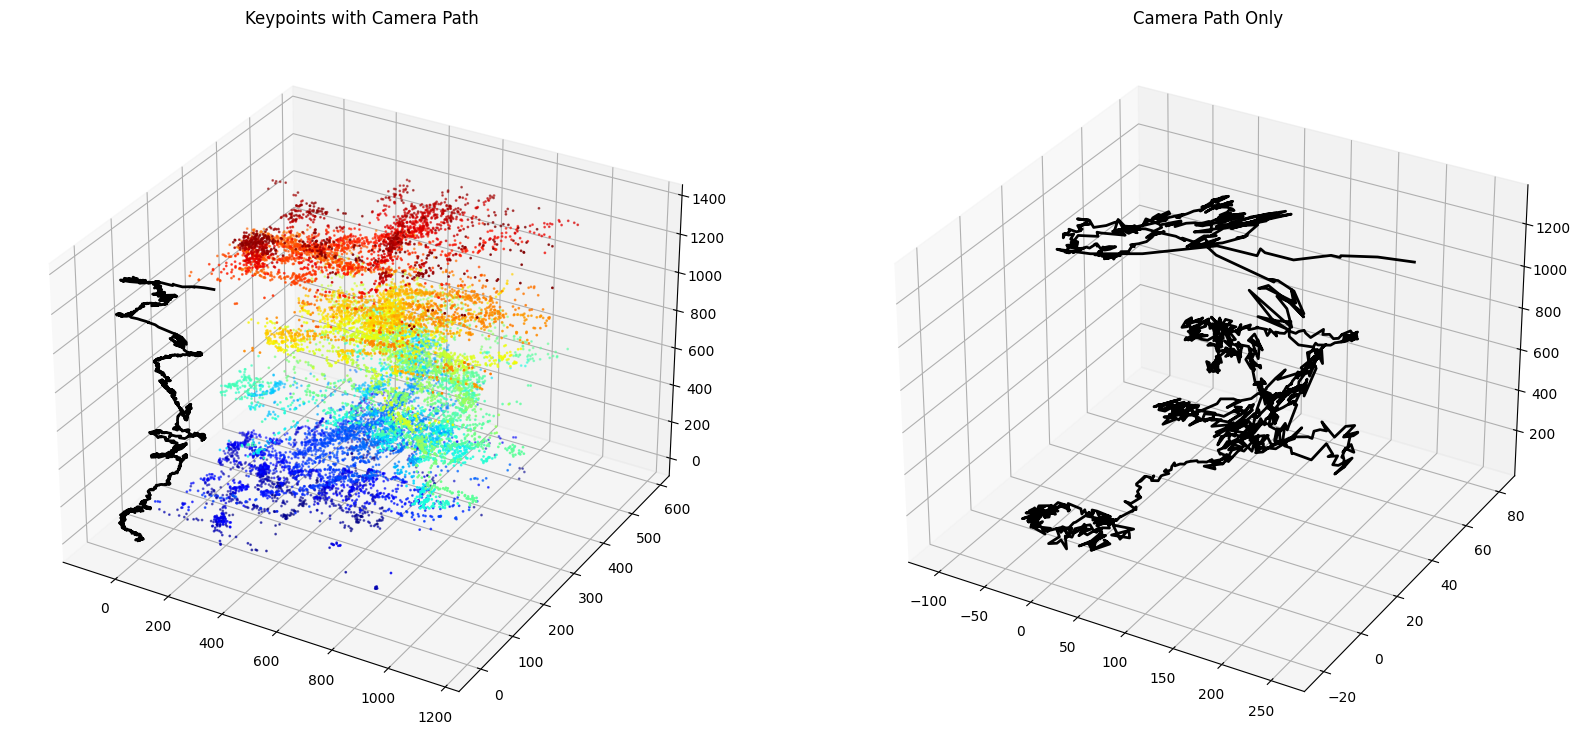

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
orb = cv2.ORB_create()
zoom_out_factor = 500  # Define the zoom out factor here

def process(frame):
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect ORB keypoints and descriptors
    keypoints, descriptors = orb.detectAndCompute(gray_frame, None)

    # In this example, we're not computing matches or 3D points,
    # so we'll return placeholders for those.
    tripoints = []  # Placeholder for 3D points
    matches = []    # Placeholder for matches

    return frame, tripoints, keypoints, matches
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    camera_positions = []  # Store the camera positions here
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts and prev_keypoints and len(kpts) == len(prev_keypoints):
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])
        else:
            dx, dy = 0, 0

        x_offset += dx
        y_offset += dy
        z_offset += 1  # Increment for every frame

        # Convert 2D keypoints to 3D with displacements
        keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
        all_points_3d.extend(keypoints_3d)

        # Store the camera position for this frame
        camera_positions.append((x_offset, y_offset, z_offset))

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)
    np_cam_positions = np.array(camera_positions)  # Convert camera positions to numpy array

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    ax = axes[0]
    ax = plt.subplot(1, 2, 1, projection='3d')
    # Scatter plot for the keypoints
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c=sampled_points[:, 2], cmap='jet', s=1)
    # Plot for the camera movement
    ax.plot(np_cam_positions[:, 0], np_cam_positions[:, 1], np_cam_positions[:, 2], color='black', linewidth=2, label="Camera Path")
    ax.set_title("Keypoints with Camera Path")

    ax = axes[1]
    ax = plt.subplot(1, 2, 2, projection='3d')
    # Plot for the camera movement only
    ax.plot(np_cam_positions[:, 0], np_cam_positions[:, 1], np_cam_positions[:, 2], color='black', linewidth=2, label="Camera Path")
    ax.set_title("Camera Path Only")

    plt.show()

if __name__ == '__main__':
    process_video("/content/mesii.mp4")


# **This code section is suppose to create camera path on Keyboard call**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow



# Assuming PointMap and Display classes definitions are already provided.

all_keypoints = []
pmap = PointMap()
display = Display()
zoom_out_factor = 500  # Define the zoom out factor here

def process(frame):
    # This function should be where you process each frame
    # And obtain the keypoints, matches, etc. For this example, I'm just simulating.
    img = frame.copy()
    tripoints = []
    kpts = [cv2.KeyPoint(x=50 * (i + 1), y=50 * (i + 1), size=5) for i in range(5)]
    matches = []
    return img, tripoints, kpts, matches

def update_camera_position(x_offset, y_offset, z_offset, camera_positions, kpts, prev_keypoints):
    if kpts and prev_keypoints and len(kpts) == len(prev_keypoints):
        dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
        dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])
    else:
        dx, dy = 0, 0

    x_offset += dx
    y_offset += dy
    z_offset += 1  # Increment for every frame

    # Store the camera position for this frame
    camera_positions.append((x_offset, y_offset, z_offset))
    return x_offset, y_offset, z_offset

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    camera_positions = []  # Store the camera positions here
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    update_camera = True  # A flag to determine whether to update the camera position

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (960, 540))
        img, tripoints, kpts, matches = process(frame)

        # If the flag is True, continue updating the camera position
        if update_camera:
            x_offset, y_offset, z_offset = update_camera_position(x_offset, y_offset, z_offset, camera_positions, kpts, prev_keypoints)

        keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
        all_points_3d.extend(keypoints_3d)

        cv2_imshow(img)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('s'):  # If 's' is pressed, toggle the camera update
            update_camera = not update_camera
        elif key == ord('q'):  # If 'q' is pressed, break out of the loop and stop processing
            break

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()
    cv2.destroyAllWindows()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)
    np_cam_positions = np.array(camera_positions)  # Convert camera positions to numpy array

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    fig = plt.figure(figsize=(15, 7))

    # Subplot for the 3D view
    ax_3d = fig.add_subplot(121, projection='3d')
    ax_3d.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c=sampled_points[:, 2], cmap='jet', s=1)
    ax_3d.plot(np_cam_positions[:, 0], np_cam_positions[:, 1], np_cam_positions[:, 2], color='red', linewidth=2, label="Camera Path")
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')
    ax_3d.set_title('3D View')

    # Subplot for the top-down view (Closure View)
    ax_closure = fig.add_subplot(122)
    ax_closure.plot(np_cam_positions[:, 0], np_cam_positions[:, 1], color='red', linewidth=2, label="Camera Path")
    ax_closure.set_xlabel('X')
    ax_closure.set_ylabel('Y')
    ax_closure.set_title('Closure View')

    # Show the 3D plot
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    process_video("/content/mesii.mp4")


In [ ]:
import cv2
import open3d as o3d
import os
import numpy as np
import matplotlib.pyplot as plt

# Your PointMap and Display classes definitions can remain unchanged.

pmap = PointMap()
display = Display()

def main():
    cap = cv2.VideoCapture("/content/test_video4.mp4")

    # Check if a GUI is available.
    has_gui = "DISPLAY" in os.environ

    if has_gui:
        pcd = o3d.geometry.PointCloud()
        visualizer = o3d.visualization.Visualizer()
        visualizer.create_window(window_name="3D plot", width=960, height=540)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))
        img, tripoints, kpts, matches = process(frame) # Ensure the process function is defined and included
        xyz = pmap.collect_points(tripoints)

        if kpts is not None or matches is not None:
            display.display_points2d(frame, kpts, matches)
        display.display_vid(frame)

        if xyz is not None:

          display.display_points3d(xyz)


        # if has_gui and xyz is not None:
        #     display.display_points3d(xyz, pcd, visualizer)

    #     if cv2.waitKey(1) == 27: # Escape key
    #         break

    # cv2.destroyAllWindows()
    # cap.release()

if __name__ == '__main__':
    main()


In [ ]:
import cv2
import open3d as o3d
import os
import numpy as np
import matplotlib.pyplot as plt

# Your PointMap and Display classes definitions can remain unchanged.

pmap = PointMap()
display = Display()
def main():
    cap = cv2.VideoCapture("/content/test_video4.mp4")

    all_points = []  # Step 1: Initialize an empty list to store all the 3D points

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))
        img, tripoints, kpts, matches = process(frame)

        xyz = pmap.collect_points(tripoints)

        # Append the new points to the all_points list
        if xyz is not None:
            all_points.extend(xyz.tolist())

        if kpts is not None or matches is not None:
            display.display_points2d(frame, kpts, matches)
        display.display_vid(frame)

    # Convert the list of all points to a numpy array
    all_points_np = np.array(all_points)

    # Step 3: Visualize the final set of 3D points
    if len(all_points_np) > 0:
        display.display_points3d(all_points_np)

    cap.release()

if __name__ == '__main__':
    main()


# **New Part**

In [ ]:
import cv2
import open3d as o3d
import os
import numpy as np
import matplotlib.pyplot as plt

# Your PointMap and Display classes definitions can remain unchanged.
all_points = []
pmap = PointMap()
display = Display()
def main():
    cap = cv2.VideoCapture("/content/suuu.mp4")

      # Step 1: Initialize an empty list to store all the 3D points

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))
        img, tripoints, kpts, matches = process(frame)

        xyz = pmap.collect_points(tripoints)

        # Append the new points to the all_points list
        if kpts is not None:
            all_points.extend(kpts)
            print(len(kpts))

        if kpts is not None or matches is not None:
            display.display_points2d(frame, kpts, matches)
        display.display_vid(frame)

    # # Convert the list of all points to a numpy array
    # all_points_np = np.array(all_points)

    # # Step 3: Visualize the final set of 3D points
    # if len(all_points_np) > 0:
    #     display.display_points3d(all_points_np)

    cap.release()

if __name__ == '__main__':
    main()


In [ ]:

import cv2
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided
all_keypoints = []
pmap = PointMap()
display = Display()

def main():
    # Read the single image
    frame = cv2.imread("/content/room.jpg")

    # Resize the image for consistent processing
    frame = cv2.resize(frame, (960, 540))
    img, tripoints, kpts, matches = process(frame) # Ensure the process function is properly defined

    # Check if keypoints are detected and then add them to the list
    if kpts is not None:
        all_keypoints.extend(kpts)
        print(kpts)

    if kpts is not None or matches is not None:
        display.display_points2d(frame, kpts, matches)
    display.display_vid(frame)

    # Note: You don't need the video release functionality for a single image

if __name__ == '__main__':
    main()


In [ ]:
import cv2
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()

def main():
    # Read the single image
    frame = cv2.imread("/content/room.jpg")
    frame1 = cv2.imread("/content/rm.jpg")

    # Resize the image for consistent processing
    frame = cv2.resize(frame, (960, 540))
    img, tripoints, kpts, matches = process(frame)  # Ensure the process function is properly defined

    # Check if keypoints are detected and then add them to the list
    if kpts is not None:
        all_keypoints.extend(kpts)
        print(f"Number of Keypoints: {len(kpts)}")

    # Draw the keypoints on the image
    img_with_kpts = cv2.drawKeypoints(frame1, kpts, None, color=(0, 255, 0))  # Green color for keypoints

    # Use matplotlib to display the image with keypoints
    plt.imshow(cv2.cvtColor(img_with_kpts, cv2.COLOR_BGR2RGB))
    plt.title('Image with Keypoints')
    plt.show()

if __name__ == '__main__':
    main()


In [ ]:
import cv2
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame1 = cv2.imread("/content/rm.jpg")
    while cap.isOpened():
        ret, frame = cap.read()

        # If the video ends or there's an issue, exit the loop
        if not ret:
            break

        # Resize for consistent processing
        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)  # Ensure the process function is properly defined

        if kpts is not None:
            all_keypoints.extend(kpts)
            print(f"Number of Keypoints: {len(kpts)}")

        # Draw the keypoints on the frame
        frame_with_kpts = cv2.drawKeypoints(frame1, kpts, None, color=(0, 255, 0))  # Green color for keypoints

        # Display the frame using matplotlib
        plt.imshow(cv2.cvtColor(frame_with_kpts, cv2.COLOR_BGR2RGB))
        plt.title('Frame with Keypoints')
        plt.show()

        # Optional: You can add a delay for a more "video-like" feel
        plt.pause(0.01)
        plt.clf()  # Clear the frame for the next one

    # Release the video capture object
    cap.release()

if __name__ == '__main__':
    process_video("/content/suuu.mp4")


In [ ]:
import cv2
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame1 = cv2.imread("/content/rm.jpg")

    while cap.isOpened():
        ret, frame = cap.read()

        # If the video ends or there's an issue, exit the loop
        if not ret:
            break

        # Resize for consistent processing
        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)  # Ensure the process function is properly defined

        if kpts is not None:
            all_keypoints.extend(kpts)
            print(f"Number of Keypoints: {len(kpts)}")

    # Release the video capture object
    cap.release()

    # Draw all the keypoints on frame1
    frame_with_all_kpts = cv2.drawKeypoints(frame1, all_keypoints, None, color=(0, 255, 0))

    # Display the frame1 with all keypoints using matplotlib
    plt.imshow(cv2.cvtColor(frame_with_all_kpts, cv2.COLOR_BGR2RGB))
    plt.title('Image with All Keypoints')
    plt.show()

if __name__ == '__main__':
    process_video("/content/suuu.mp4")


In [ ]:
import cv2
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    z_increment = 0.5  # Increment value for z-axis
    z_value = 0  # Start value for z-axis

    all_points_3d = []

    while cap.isOpened():
        ret, frame = cap.read()

        # If the video ends or there's an issue, exit the loop
        if not ret:
            break

        # Resize for consistent processing
        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)  # Ensure the process function is properly defined

        if kpts is not None:
            # Convert 2D keypoints to 3D by adding a z-value
            keypoints_3d = [(kp.pt[0], kp.pt[1], z_value) for kp in kpts]
            all_points_3d.extend(keypoints_3d)

            z_value += z_increment

    # Release the video capture object
    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)

    # Create an open3d PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_points)

    # Visualize using open3d
    o3d.visualization.draw_geometries([pcd])

if __name__ == '__main__':
    process_video("/content/suuu.mp4")


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts is not None and prev_keypoints is not None:
            # Calculate average displacements
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])

            x_offset += dx
            y_offset += dy
            z_offset += 1  # Increment for every frame

            # Convert 2D keypoints to 3D with displacements
            keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
            all_points_3d.extend(keypoints_3d)

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    fig = plt.figure(figsize=(10, 10))  # Make the overall figure larger
    ax = fig.add_subplot(111, projection='3d')

    # Use the `s` parameter to set the size of each point. For instance, setting it to 1 will make the points quite small.
    ax.scatter(sampled_points[:,2], sampled_points[:,1], sampled_points[:,0], c=sampled_points[:,2], cmap='jet', s=1)

    # Set axis limits to make them appear "larger"
    ax.set_xlim([np.min(sampled_points[:,2]) - 50, np.max(sampled_points[:,2]) + 50])
    ax.set_ylim([np.min(sampled_points[:,1]) - 50, np.max(sampled_points[:,1]) + 50])
    ax.set_zlim([np.min(sampled_points[:,0]) - 50, np.max(sampled_points[:,0]) + 50])

    plt.show()

if __name__ == '__main__':
    process_video("/content/suuu.mp4")


In [ ]:
#grid
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts is not None and prev_keypoints is not None:
            # Calculate average displacements
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])

            x_offset += dx
            y_offset += dy
            z_offset += 1  # Increment for every frame

            # Convert 2D keypoints to 3D with displacements
            keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
            all_points_3d.extend(keypoints_3d)

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with small point size
    ax.scatter(sampled_points[:,2], sampled_points[:,1], sampled_points[:,0], c=sampled_points[:,2], cmap='jet', s=1)

    # Increase the span of axis limits for a zoomed-out view
    zoom_out_factor = 100
    ax.set_xlim([np.min(sampled_points[:,2]) - zoom_out_factor, np.max(sampled_points[:,2]) + zoom_out_factor])
    ax.set_ylim([np.min(sampled_points[:,1]) - zoom_out_factor, np.max(sampled_points[:,1]) + zoom_out_factor])
    ax.set_zlim([np.min(sampled_points[:,0]) - zoom_out_factor, np.max(sampled_points[:,0]) + zoom_out_factor])

    plt.show()

if __name__ == '__main__':
    process_video("/content/suuu.mp4")


# **Demo 1**

# **Good Result**

In [ ]:
#gridless
#demo1
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts is not None and prev_keypoints is not None:
            # Calculate average displacements
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])

            x_offset += dx
            y_offset += dy
            z_offset += 1  # Increment for every frame

            # Convert 2D keypoints to 3D with displacements
            keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
            all_points_3d.extend(keypoints_3d)

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with small point size
    ax.scatter(sampled_points[:,2], sampled_points[:,1], sampled_points[:,0], c=sampled_points[:,2], cmap='jet', s=1)

    # Increase the span of axis limits for a zoomed-out view
    zoom_out_factor = 500
    ax.set_xlim([np.min(sampled_points[:,2]) - zoom_out_factor, np.max(sampled_points[:,2]) + zoom_out_factor])
    ax.set_ylim([np.min(sampled_points[:,1]) - zoom_out_factor, np.max(sampled_points[:,1]) + zoom_out_factor])
    ax.set_zlim([np.min(sampled_points[:,0]) - zoom_out_factor, np.max(sampled_points[:,0]) + zoom_out_factor])

        # Turn off the axis grid
    ax.grid(False)

        # Set background color to white
    ax.set_facecolor('white')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Optionally, turn off the axis labels for a cleaner visualization
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Hide axes ticks
    for axis in ['x', 'y', 'z']:
        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])

    plt.show()

if __name__ == '__main__':
    process_video("/content/suuu.mp4")


## **Intermediate**

In [ ]:
#gridless
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts is not None and prev_keypoints is not None:
            # Calculate average displacements
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])

            x_offset += dx
            y_offset += dy
            z_offset += 1  # Increment for every frame

            # Convert 2D keypoints to 3D with displacements
            keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
            all_points_3d.extend(keypoints_3d)

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with small point size
    ax.scatter(sampled_points[:,2], sampled_points[:,1], sampled_points[:,0], c=sampled_points[:,2], cmap='jet', s=1)

    # Increase the span of axis limits for a zoomed-out view
    zoom_out_factor = 500
    ax.set_xlim([np.min(sampled_points[:,0]) - zoom_out_factor, np.max(sampled_points[:,0]) + zoom_out_factor])
    ax.set_ylim([np.min(sampled_points[:,1]) - zoom_out_factor, np.max(sampled_points[:,1]) + zoom_out_factor])
    ax.set_zlim([np.min(sampled_points[:,2]) - zoom_out_factor, np.max(sampled_points[:,2]) + zoom_out_factor])

    # Turn off the axis grid
    ax.grid(False)

    # Set background color to white
    ax.set_facecolor('white')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Turn off the axis labels for a cleaner visualization
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Hide axes ticks
    for axis in ['x', 'y', 'z']:
        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])

    plt.show()

if __name__ == '__main__':
    process_video("/content/mesii.mp4")


# **Demo 2**

In [ ]:
#demo2
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming PointMap and Display classes definitions are already provided.
all_keypoints = []
pmap = PointMap()
display = Display()

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    all_points_3d = []
    x_offset, y_offset, z_offset = 0, 0, 0
    prev_keypoints = None  # Store the keypoints of the previous frame outside the loop

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.resize(frame, (960, 540))

        img, tripoints, kpts, matches = process(frame)

        if kpts is not None and prev_keypoints is not None:
            # Calculate average displacements
            dx = np.mean([kpt.pt[0] - prev.pt[0] for kpt, prev in zip(kpts, prev_keypoints)])
            dy = np.mean([kpt.pt[1] - prev.pt[1] for kpt, prev in zip(kpts, prev_keypoints)])

            x_offset += dx
            y_offset += dy
            z_offset += 1  # Increment for every frame

            # Convert 2D keypoints to 3D with displacements
            keypoints_3d = [(kp.pt[0] + x_offset, kp.pt[1] + y_offset, z_offset) for kp in kpts]
            all_points_3d.extend(keypoints_3d)

        # After processing the keypoints, set the current keypoints to the previous keypoints for the next iteration
        prev_keypoints = kpts

    cap.release()

    # Convert to numpy array for visualization
    np_points = np.array(all_points_3d)

    # Sample the points to reduce density. Here, we take every 50th point.
    sampled_points = np_points[::50]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with small point size
    ax.scatter(sampled_points[:,1], sampled_points[:,0], sampled_points[:,2], c=sampled_points[:,2], cmap='jet', s=1)

    # Increase the span of axis limits for a zoomed-out view
    zoom_out_factor = 500
    ax.set_ylim([np.min(sampled_points[:,1]) - zoom_out_factor, np.max(sampled_points[:,1]) + zoom_out_factor])
    ax.set_xlim([np.min(sampled_points[:,0]) - zoom_out_factor, np.max(sampled_points[:,0]) + zoom_out_factor])
    ax.set_zlim([np.min(sampled_points[:,2]) - zoom_out_factor, np.max(sampled_points[:,2]) + zoom_out_factor])

    # Turn off the axis grid
    ax.grid(False)

    # Set background color to white
    ax.set_facecolor('white')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Turn off the axis labels for a cleaner visualization
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Hide axes ticks
    for axis in ['x', 'y', 'z']:
        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])

    plt.show()

if __name__ == '__main__':
    process_video("/content/suuu.mp4")


## **Error**

In [ ]:
import matplotlib.pyplot as plt

# Extract x, y, z coordinates from all_points for plotting
x_coords = [pt[0] for pt in all_points]
y_coords = [pt[1] for pt in all_points]
z_coords = [pt[2] for pt in all_points]

# Create a new figure for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x_coords, y_coords, z_coords, c='blue', marker='o', s=1)  # You can customize the color, marker, and size

# Setting labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter plot of all_points')

plt.show()
